In [17]:
import pandas as pd

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

data_dnase = pd.read_csv("/mnt/lab_data2/anusri/variant-scorer/src/output/caqtls_lcl_latest/DNASE/summary.mean.variant_scores_new.tsv", sep="\t", header=0)
data_dnase[['Chrx', 'Posx', 'REF', 'ALT']] = data_dnase['rsid'].str.split("_", expand=True)
data_dnase["jsd_sign.mean"] = data_dnase["jsd.mean"]*np.sign(data_dnase["logfc.mean"])

data_atac = pd.read_csv("/mnt/lab_data2/anusri/variant-scorer/src/output/caqtls_lcl_latest/ATAC/summary.mean.variant_scores_new.tsv", sep="\t", header=0)
data_atac[['Chrx', 'Posx', 'REF', 'ALT']] = data_atac['rsid'].str.split("_", expand=True)
data_atac["jsd_sign.mean"] = data_atac["jsd.mean"]*np.sign(data_atac["logfc.mean"])

data_atac_50m = pd.read_csv("/mnt/lab_data2/anusri/enformer/caqtls/set_sig20/chrombpnet_preds/atac_50M_model/ATAC_50M/summary.mean.variant_scores_new_2.tsv", sep="\t", header=0)
data_atac_50m[['Chrx', 'Posx', 'REF', 'ALT']] = data_atac_50m['rsid'].str.split("_", expand=True)
data_atac_50m["jsd_sign.mean"] = data_atac_50m["jsd.mean"]*np.sign(data_atac_50m["logfc.mean"])

#data_enf = pd.read_csv("/mnt/lab_data2/anusri/enformer/caqtls/set_sig20/enformer_predictions.tsv", sep="\t", header=0)

def  get_auprc_curves(data_atac, data_dnase, data_atac_50m):

    qvals = pd.read_csv("/mnt/lab_data2/anusri/enformer/caqtls/set_sig20/source1.tsv", sep="\t", header=0)
    print("source:",qvals.shape)
    
    data_enf = pd.read_csv("/mnt/lab_data2/anusri/enformer/caqtls/set_sig20/enformer_predictions1.tsv", sep="\t", header=0).drop_duplicates()
    qvals["rsidn"] = qvals["chr"] + "_" + qvals["Pos"].astype("str") + "_"  + qvals["Ref"] + "_"  + qvals["Alt"]
    data_enf["rsid1"] = data_enf["chr"] + "_" + data_enf["pos"].astype(int).astype("str") + "_"  + data_enf["ref"] + "_"  + data_enf["alt"]
    data_enf["rsid2"] = data_enf["chr"] + "_" + data_enf["pos"].astype(int).astype("str") + "_"  + data_enf["alt"] + "_"  + data_enf["ref"]

    merged_enf1 = data_enf.merge(qvals, how="right", left_on=["rsid1"], right_on=["rsidn"]).drop_duplicates()
    merged_enf1 = merged_enf1[~np.isnan(merged_enf1["DNASE_SAD"])]
    merged_enf2 = data_enf.merge(qvals, how="right", left_on=["rsid2"], right_on=["rsidn"]).drop_duplicates()
    merged_enf2 = merged_enf2[~np.isnan(merged_enf2["DNASE_SAD"])]
    merged_enf2["DNASE_SAD"] = merged_enf2["DNASE_SAD"]*-1
    merged_enf2["DNASE_SAR"] = merged_enf2["DNASE_SAR"]*-1
 
    merged_enf = pd.concat([merged_enf1,merged_enf2])
    print("Enf:",merged_enf.shape)
    #print(merged_enf.head())
    
    # source 
    qvals = qvals[qvals["rsidn"].isin(merged_enf["rsidn"])]
    
    #print(data_atac.shape)
    merged_atac = data_atac.merge(qvals, how="right", left_on=["chr", "allele1", "allele2", "pos"], right_on=["chr", "Ref", "Alt", "Pos"]).drop_duplicates()
    merged_atac_50m = data_atac_50m.merge(qvals, how="right", left_on=["chr", "allele1", "allele2", "pos"], right_on=["chr", "Ref", "Alt", "Pos"]).drop_duplicates()
    merged_dnase = data_dnase.merge(qvals, how="right", left_on=["chr", "allele1", "allele2", "pos"], right_on=["chr", "Ref", "Alt", "Pos"]).drop_duplicates()
    print("ATAC shape",merged_atac.shape)
    
    keyd="abs_logfc_x_jsd_x_max_percentile.mean"

    fpr_chrombpnet, tpr_chrombpnet, _ = precision_recall_curve(merged_atac["label"].astype(int), abs(merged_atac[keyd]))
    roc_auc = metrics.average_precision_score(merged_atac["label"], abs(merged_atac[keyd]))
    plt.plot(tpr_chrombpnet,fpr_chrombpnet,  linewidth=2, c='blue', linestyle='dashed', label="ChromBPNet w/ ATAC, AP="+str(round(roc_auc,2)))
    #print(roc_auc)

    fpr_chrombpnet, tpr_chrombpnet, _ = precision_recall_curve(merged_atac_50m["label"].astype(int), abs(merged_atac_50m[keyd]))
    roc_auc = metrics.average_precision_score(merged_atac_50m["label"], abs(merged_atac_50m[keyd]))
    plt.plot(tpr_chrombpnet,fpr_chrombpnet,  linewidth=2, c='blue', label="ChromBPNet w/ ATAC, AP="+str(round(roc_auc,2)))
    #print(roc_auc)

    fpr_chrombpnet, tpr_chrombpnet, _ = precision_recall_curve(merged_dnase["label"].astype(int), abs(merged_dnase[keyd]))
    roc_auc = metrics.average_precision_score(merged_dnase["label"], abs(merged_dnase[keyd]))
    plt.plot(tpr_chrombpnet,fpr_chrombpnet,  linewidth=2, c='cyan', label="ChromBPNet w/ DNase, AP="+str(round(roc_auc,2)))
    #print(roc_auc)
    
    #enformer
    
    fpr_chrombpnet, tpr_chrombpnet, _ = precision_recall_curve(merged_enf["label"].astype(int), abs(merged_enf["DNASE_SAR"]))
    roc_auc = metrics.average_precision_score(merged_enf["label"], abs(merged_enf["DNASE_SAR"]))
    plt.plot(tpr_chrombpnet,fpr_chrombpnet,  linewidth=2, c='orange', label="Enformer SAD, AP="+str(round(roc_auc,2)))
    #print(roc_auc)
    
    plt.legend()
    #plt.show()
    #plt.savefig("subfigs_new/dsqtls_final.pdf", transparent=True, dpi=300)
    
#     plt.Figure()
#     plt.scatter(merged_enf["DNASE_SAD"][merged_enf["label"]==1], merged_enf["Beta"][merged_enf["label"]==1])
#     plt.show()
    
    print("Random: ", np.round(sum(merged_atac["label"]==1)/merged_atac.shape[0],2))
    keyd="jsd_sign.mean"

    print(sum(merged_atac["label"]==1))
    print("ChromBPNet ATAC: ", np.round(scipy.stats.pearsonr(merged_atac[keyd][merged_atac["label"]==1], merged_atac["Beta"][merged_atac["label"]==1])[0],2))
    print("ChromBPNet ATAC: ", np.round(scipy.stats.pearsonr(merged_atac_50m[keyd][merged_atac_50m["label"]==1], merged_atac_50m["Beta"][merged_atac_50m["label"]==1])[0],2))
    print("ChromBPNet DNase: ", np.round(scipy.stats.pearsonr(merged_dnase[keyd][merged_dnase["label"]==1], merged_dnase["Beta"][merged_dnase["label"]==1])[0],2))
    print("Enformer: ",np.round(scipy.stats.pearsonr(merged_enf["DNASE_SAD"][merged_enf["label"]==1], merged_enf["Beta"][merged_enf["label"]==1])[0],2))

    print("ChromBPNet ATAC: ", scipy.stats.pearsonr(merged_atac[keyd][merged_atac["label"]==1], merged_atac["Beta"][merged_atac["label"]==1])[1])
    print("ChromBPNet ATAC: ", scipy.stats.pearsonr(merged_atac_50m[keyd][merged_atac_50m["label"]==1], merged_atac_50m["Beta"][merged_atac_50m["label"]==1])[1])
    print("ChromBPNet DNase: ",scipy.stats.pearsonr(merged_dnase[keyd][merged_dnase["label"]==1], merged_dnase["Beta"][merged_dnase["label"]==1])[1])
    print("Enformer: ",scipy.stats.pearsonr(merged_enf["DNASE_SAD"][merged_enf["label"]==1], merged_enf["Beta"][merged_enf["label"]==1])[1])
    
    import seaborn as sns

    plt.figure(figsize=(8,5))
    data = pd.DataFrame()
    data["sd_sign.mean"] = merged_atac[merged_atac["label"]==1]["jsd_sign.mean"]
    data["Beta"] = merged_atac[merged_atac["label"]==1]["Beta"]
    data["logfc_x_max_percentile.mean"] = abs(merged_atac[merged_atac["label"]==1]["max_percentile.mean"])

    sns.scatterplot(data=data, y="sd_sign.mean", x="Beta", hue="logfc_x_max_percentile.mean", s=10)
    #plt.show()
    #plt.savefig("subfigs_new/dsqtls_final.pdf", transparent=True, dpi=300)


source: (45390, 7)
Enf: (45390, 17)
ATAC shape (45390, 35)
Random:  0.02
890
ChromBPNet ATAC:  0.59
ChromBPNet ATAC:  0.6
ChromBPNet DNase:  0.61
Enformer:  0.44
ChromBPNet ATAC:  2.6143639485677044e-86
ChromBPNet ATAC:  1.1267082836016674e-86
ChromBPNet DNase:  1.6706179667313613e-91
Enformer:  1.193930091984343e-43


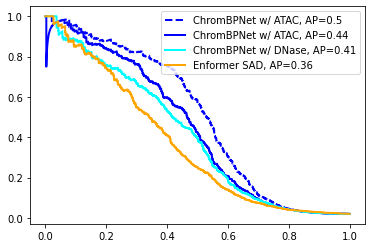

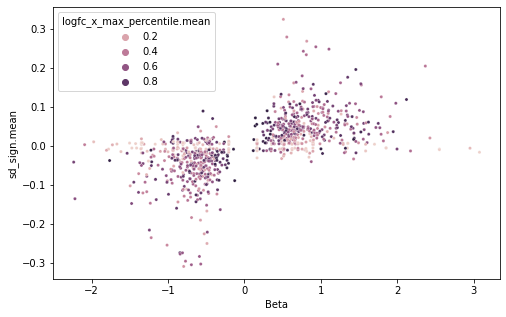

In [20]:
get_auprc_curves(data_atac, data_dnase,data_atac_50m)

In [16]:
merged_atac["label"]

NameError: name 'merged_atac' is not defined